## Camera calibration and undistortion

Calibrate the camera using provided images in `camera_cal` directory.
Pickup a single image in the `camera_cal` directory and see undistortion works well.

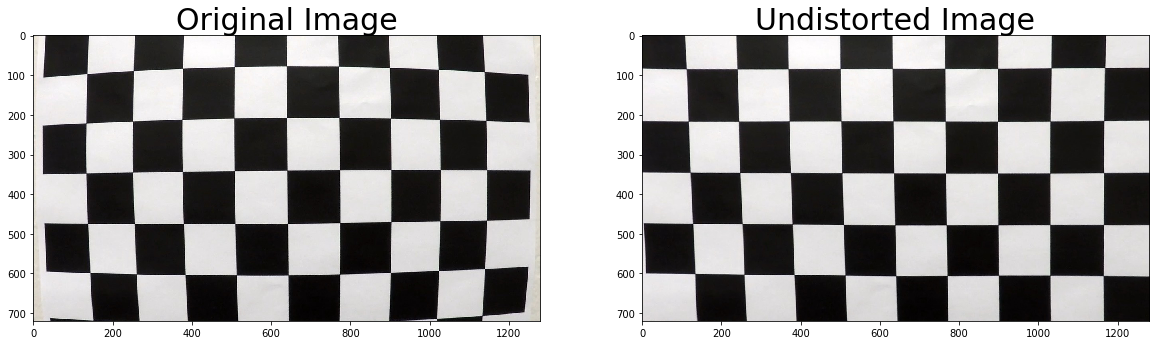

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle

import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,4,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration1*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

        
# Save mtx, dist
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./calibration_result/calibration_result_pickle.p", "wb" ) )

# Check result with a single image.
sample = mpimg.imread('./camera_cal/calibration1.jpg')
sample_undist = cv2.undistort(sample, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sample_undist)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply undistortion to test images

Apply undistortion with the calibration parameters obtained in previous steps.
After the undistortion, choose four coners to execute perspective transform.

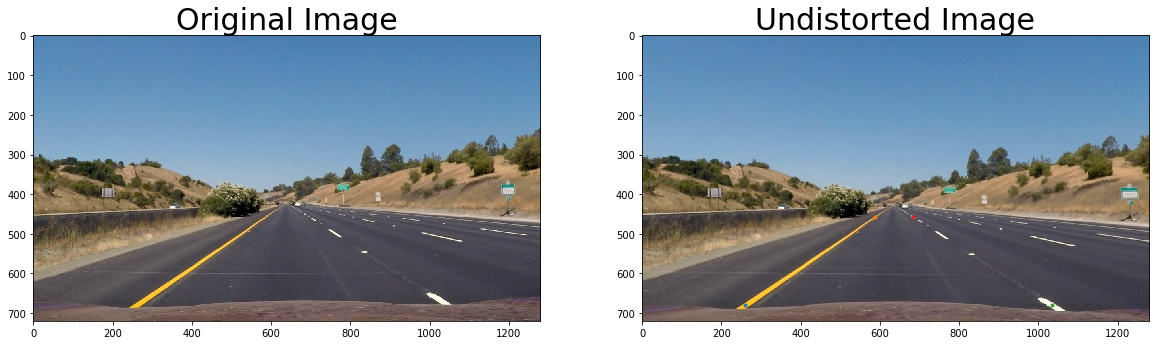

In [99]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
c_result = pickle.load(open('calibration_result/calibration_result_pickle.p','rb'))
mtx = c_result['mtx']
dist = c_result['dist']

undist = cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

#mpimg.imsave('./output_images/undist_straight_lines1.jpg', undist)

src_bottom_left = [261.0, 680.0]
src_upper_left = [588.0, 457.0]
src_bottom_right = [1034.0, 680.0]
src_upper_right = [684.0, 457.0]
ax2.plot(src_bottom_left[0], src_bottom_left[1], '.')
ax2.plot(src_upper_left[0], src_upper_left[1], '.')
ax2.plot(src_bottom_right[0], src_bottom_right[1], '.')
ax2.plot(src_upper_right[0], src_upper_right[1], '.')

## Perspective transform
Execute perspective transform.

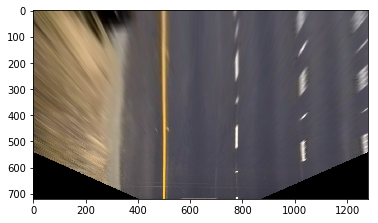

In [101]:
src = np.float32([
    src_bottom_left,
    src_upper_left,
    src_bottom_right,
    src_upper_right
])

dst_bottom_left = [500, 720]
dst_upper_left = [500,0]
dst_bottom_right = [780, 720]
dst_upper_right = [780, 0]
dst = np.float32([
    dst_bottom_left,
    dst_upper_left,
    dst_bottom_right,
    dst_upper_right
])

M = cv2.getPerspectiveTransform(src, dst)
img_size = (undist.shape[1], undist.shape[0])
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)

In [103]:
def prepare_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    img_size = (undist.shape[1], undist.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped

## Apply undistortion/ perspective transfrom to all test images.

Apply undistortion, perspective transfrom to all test images provided in `test_images` directory.

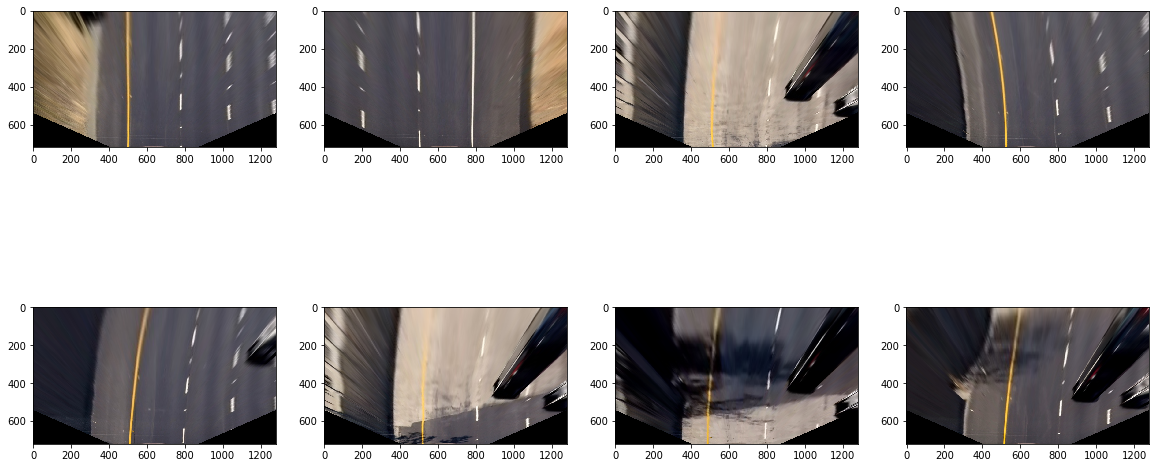

In [119]:
test_images = glob.glob('./test_images/*.jpg')

f, subs = plt.subplots(2, 4, figsize=(20,10))
for idx, fname in enumerate(test_images):
#    image = cv2.imread(fname)
    image = mpimg.imread(fname)
    warped = prepare_image(image)
    if 0 <= idx and idx <= 3:
        subs[0][idx].imshow(warped)
    else:
        subs[1][idx%4].imshow(warped)

In [184]:
#def convert_color(img, s_thresh=(180, 240), sx_thresh=(20, 35)):
def convert_color(img, s_thresh=(140, 250), sx_thresh=(30, 50)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=31) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

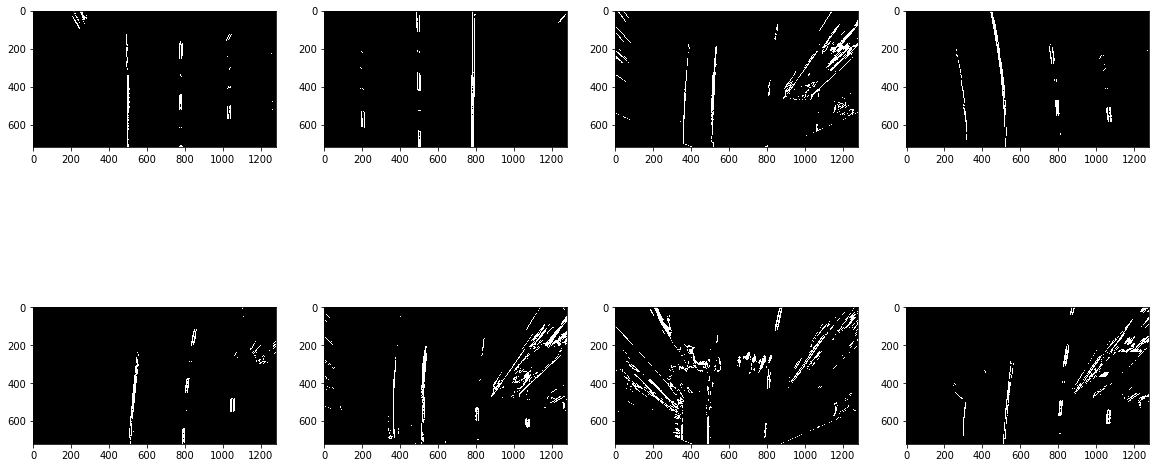

In [187]:
f, subs = plt.subplots(2, 4, figsize=(20,10))
for idx, fname in enumerate(test_images):
    image = cv2.imread(fname)
    warped = prepare_image(image)
    converted = convert_color(warped, s_thresh=(150, 245), sx_thresh=(100, 255))
    if 0 <= idx and idx <= 3:
        subs[0][idx].imshow(converted, cmap='gray')
    else:
        subs[1][idx%4].imshow(converted, cmap='gray')